In [2]:
FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'

In [3]:
import pandas as pd
from datetime import datetime
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from tqdm import tqdm

from helper import *

In [136]:
NROWS = 1_000_000

In [137]:
data = pd.read_csv(DATASETS_PATH + 'data_processed.csv', nrows=NROWS).drop(columns=['Unnamed: 0'])
data['datetime'] = pd.to_datetime(data['datetime'])
data

,gid,transaction_key,store_id,product_id,line_item_price,line_item_cost,line_type,datetime,category_id,weekday,line_quantity
0,0,0,2,0,2990.0,2516.10,0,2022-04-18 12:22:18,NaN,0,1.0
1,1,1,3,1,1413.0,1206.73,1,2022-08-26 18:00:29,NaN,4,2.0
2,1,1,3,2,338.0,179.51,1,2022-08-26 18:00:29,NaN,4,4.0
3,1,1,3,3,1634.0,1402.83,1,2022-08-26 18:00:29,NaN,4,1.0
4,1,1,3,4,78.0,61.70,1,2022-08-26 18:00:29,NaN,4,40.0
...,...,...,...,...,...,...,...,...,...,...,...
999995,124365,190992,3,1067,90.0,68.52,0,2022-11-05 09:06:54,NaN,5,1.0
999996,124365,190992,3,316,43.0,25.22,0,2022-11-05 09:06:54,NaN,5,14.0
999997,124365,190992,3,34581,13.0,5.46,0,2022-11-05 09:06:54,NaN,5,2.0
999998,124365,190992,3,7377,36.0,13.62,0,2022-11-05 09:06:54,NaN,5,1.0


### Функции вывода графиков

In [6]:
def scatter_prices(data, line_article_id):
    these_prices = data.loc[data['product_id'] == line_article_id][['line_item_price', 'datetime', 'line_quantity']]
    grouped_prices = these_prices.groupby(['line_item_price'])
    ans = grouped_prices['line_quantity'].apply(lambda x: x.sum())

    ans_cnt = grouped_prices['line_quantity'].apply(lambda x: len(x))
    cnt = (ans_cnt.array - ans_cnt.array.min()) / (ans_cnt.array.max() - ans_cnt.array.min())
    cnt *= 50

    prices, counts = ans.axes, ans.array

    fig1, ax1 = plt.subplots(figsize=(20, 10))
    fig2, ax2 = plt.subplots(figsize=(20, 10))

    fig1.suptitle('Items')
    fig2.suptitle('Buyers')

    ax1.set_xlabel("Price, RUR")
    ax1.set_ylabel("Count of items")
    ax1.grid(axis='x', which='major')

    ax1.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax1.scatter(prices[0], counts, s=cnt, c=counts, cmap='cool')

    ax2.set_xlabel("Price, RUR")
    ax2.set_ylabel("Count of buyers")
    ax2.grid(axis='x', which='major')

    ax2.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax2.scatter(prices[0], cnt, s=cnt, c=counts, cmap='cool')


    # plot = ax2.pcolor(counts)
    # fig2.colorbar(plot)

# scatter_prices(data, 15058563)


In [49]:
def scatter_mean_prices(data, ylim=None):
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.scatter(data.index, data['average_price'], s=0.2)

    x = data['average_price']
    m, s = x.mean(), x.std()

    ax.axhline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axhline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axhline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_ylim(bottom=0, top=ylim)
    ax.set_xlim(left=0)
    ax.set_xlabel('Users')
    ax.set_ylabel('Mean price')
    ax.set_title('Mean prices')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_mean_prices')

In [50]:
def scatter_hist_of_prices(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['average_price'].values
    m, s = x.mean(), x.std()


    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)
    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')

    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Mean price of purchases')
    ax.set_ylabel('Count of buyers')
    ax.set_title('Histogram of frequency')
    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_hist')

In [51]:
def scatter_hist_of_products(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['line_item_price'].values

    m, s = x.mean(), x.std()
    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Price of product')
    ax.set_ylabel('Count of products')
    ax.set_title('Histogram of frequency')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'products_hist')

In [44]:
def scatter_hist_of_weekdays(data):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['weekday'].values

    ax.hist(x, bins=7, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.set_xlabel('Weekday')
    ax.set_ylabel('Count of purchases')
    ax.set_title('Histogram of weekdays')
    ax.set_xticks([i for i in range(0, 7)], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation='vertical')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'weekdays_hist')

In [11]:
def scatter_pie_of_prices(data, nbins=5, top_limit=10_000):
    fig, ax = plt.subplots(figsize=(20, 10))
    x, bin_edges = np.histogram(data['line_item_price'].values, bins=nbins, range=(0, top_limit))
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    ax.pie(x, colors=colors, radius=2, center=(4, 4), labels=['<' + str(i) for i in bin_edges[1:]],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, autopct='%1.1f%%')

In [96]:
def plot_over_time(data):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date.value_counts()
    dates_ma = dates.rolling(5).mean()
    dates_ma.plot(alpha=0.3, color='r')

    dates.plot()
    plt.show()

In [141]:
def scatter_hist_over_time(data, nbins=None, plot_ma=False):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date

    mi, ma = dates.min(), dates.max()

    opti_bins = (ma - mi).days
    if nbins is None:
        nbins = opti_bins
    dates.hist(bins=nbins, histtype='bar', edgecolor='black', linewidth=1.1)

    if plot_ma:
        ma = dates.value_counts().rolling(20).mean()
        ma.plot(color='r', alpha=0.4)



### Анализ

In [12]:
def get_date_info(data):
    data = data[['product_id', 'gid', 'datetime', 'weekday', 'line_item_price']]
    grouped_by_date = data.groupby(by='datetime')

    ans = grouped_by_date[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})

    ans['unique_users'] = grouped_by_date['gid'].apply(lambda x: x.nunique())

    ans['average_price'] = grouped_by_date['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_date['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_date['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_date['datetime'].apply(lambda x: get_mean(get_time_delta(x)))

    return ans

In [13]:
def get_weekday_info(data):
    grouped_by_weekday = data.groupby(by='weekday')
    ans = grouped_by_weekday[['transaction_key']].apply(lambda x: x.nunique()).rename(columns={'transaction_key': 'unique_receipts'})

    ans['average_receipt_sum'] = grouped_by_weekday['line_item_price'].apply(lambda x: x.values.sum() / x.values.shape[0])
    ans['unique_users'] = grouped_by_weekday['gid'].apply(lambda x: x.nunique())
    return ans
    #
    # return ans

In [14]:
weekday_info = get_weekday_info(data)
weekday_info

,unique_receipts,average_receipt_sum,unique_users
weekday,,,
0,2362,595.482694,2339
1,2580,611.175909,2549
2,2593,566.916601,2564
3,2666,600.635460,2630
4,2757,623.061371,2736
5,3321,591.080437,3289
6,3061,587.862218,3036


In [15]:
# from helper import get_median

def get_product_info(data):
    data = data[['product_id', 'line_item_price', 'store_id', 'line_item_cost', 'datetime', 'line_quantity', 'gid']]
    grouped_by_product = data.groupby(by='product_id')

    ans = grouped_by_product[['gid']].apply(lambda x: x.nunique()).rename(columns={'gid': 'unique_users'})

    ans['average_price'] = grouped_by_product['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_product['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_product['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_product['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    return ans


In [16]:
product_info = get_product_info(data)
product_info

,unique_users,average_price,median_price,average_quantity,average_date_delta
product_id,,,,,
0,4,2990.000000,2990.0,1.000000,40 days 23:07:05.333333333
1,46,1436.021739,1456.5,1.608696,7 days 14:22:45.777777777
2,1,338.000000,338.0,4.000000,NaT
3,29,1782.655172,1784.0,1.482759,12 days 17:44:38.392857142
4,2,78.000000,78.0,21.000000,105 days 01:20:55
...,...,...,...,...,...
29803,1,646.000000,646.0,1.000000,NaT
29804,1,450.000000,450.0,2.000000,NaT
29805,1,168.000000,168.0,1.000000,NaT


In [17]:
def get_user_info(data):
    """
    :param data: receipts - pandas.DataFrame
    :return: ans: info for every user - pandas.DataFrame
    """

    grouped_by_user = data[['gid', 'line_item_price', 'product_id']].groupby(by='gid')
    ans = grouped_by_user[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})
    ans['average_price'] = grouped_by_user['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['quantile_0.25'] = grouped_by_user['line_item_price'].quantile(0.25)
    ans['median_price'] = grouped_by_user['line_item_price'].apply(lambda x: get_median(x))
    ans['quantile_0.75'] = grouped_by_user['line_item_price'].quantile(0.75)
    ans['quartile_range'] = ans['quantile_0.75'] - ans['quantile_0.25']
    ans['std'] = grouped_by_user['line_item_price'].std()
    # ans['average_date_delta'] = grouped_by_user['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    # ans['date_quartile_range'] = grouped_by_user['datetime'].apply(lambda x: get_quartile_range(get_time_delta(x)))
    return ans



In [18]:
user_info = get_user_info(data)
user_info

,unique_products,average_price,quantile_0.25,median_price,quantile_0.75,quartile_range,std
gid,,,,,,,
0,1,2990.000000,2990.00,2990.0,2990.00,0.00,NaN
1,46,470.278261,86.75,175.5,502.00,415.25,815.889769
2,1,941.000000,941.00,941.0,941.00,0.00,NaN
3,1,850.000000,850.00,850.0,850.00,0.00,NaN
4,4,876.750000,237.50,369.5,1008.75,771.25,1202.269070
...,...,...,...,...,...,...,...
18581,5,279.000000,80.00,256.0,353.00,273.00,248.756909
18582,1,58.000000,58.00,58.0,58.00,0.00,NaN
18583,1,1300.000000,1300.00,1300.0,1300.00,0.00,NaN


In [19]:
def three_sigmas(ser):
    mean = ser.mean()
    std = ser.std()

    one_sigma = ser.loc[ser > mean - std].loc[ser < mean + std].shape[0] / ser.shape[0]
    two_sigma = ser.loc[ser > mean - 2 * std].loc[ser < mean + 2 * std].shape[0] / ser.shape[0]
    three_sigma = ser.loc[ser > mean - 3 * std].loc[ser < mean + 3 * std].shape[0] / ser.shape[0]
    return one_sigma, two_sigma, three_sigma

In [20]:
user_info.apply(three_sigmas)

,unique_products,average_price,quantile_0.25,median_price,quantile_0.75,quartile_range,std
0,0.890939,0.950500,0.957764,0.953729,0.946788,0.947487,0.742979
1,0.952384,0.975842,0.977564,0.976272,0.973690,0.976057,0.769396
2,0.980093,0.986011,0.986926,0.986065,0.984881,0.985581,0.777844


In [21]:
product_info.apply(three_sigmas)

,unique_users,average_price,median_price,average_quantity,average_date_delta
0,0.986447,0.937399,0.937601,0.960044,0.399557
1,0.995773,0.969706,0.969572,0.983427,0.466989
2,0.997819,0.982555,0.982488,0.990976,0.484400


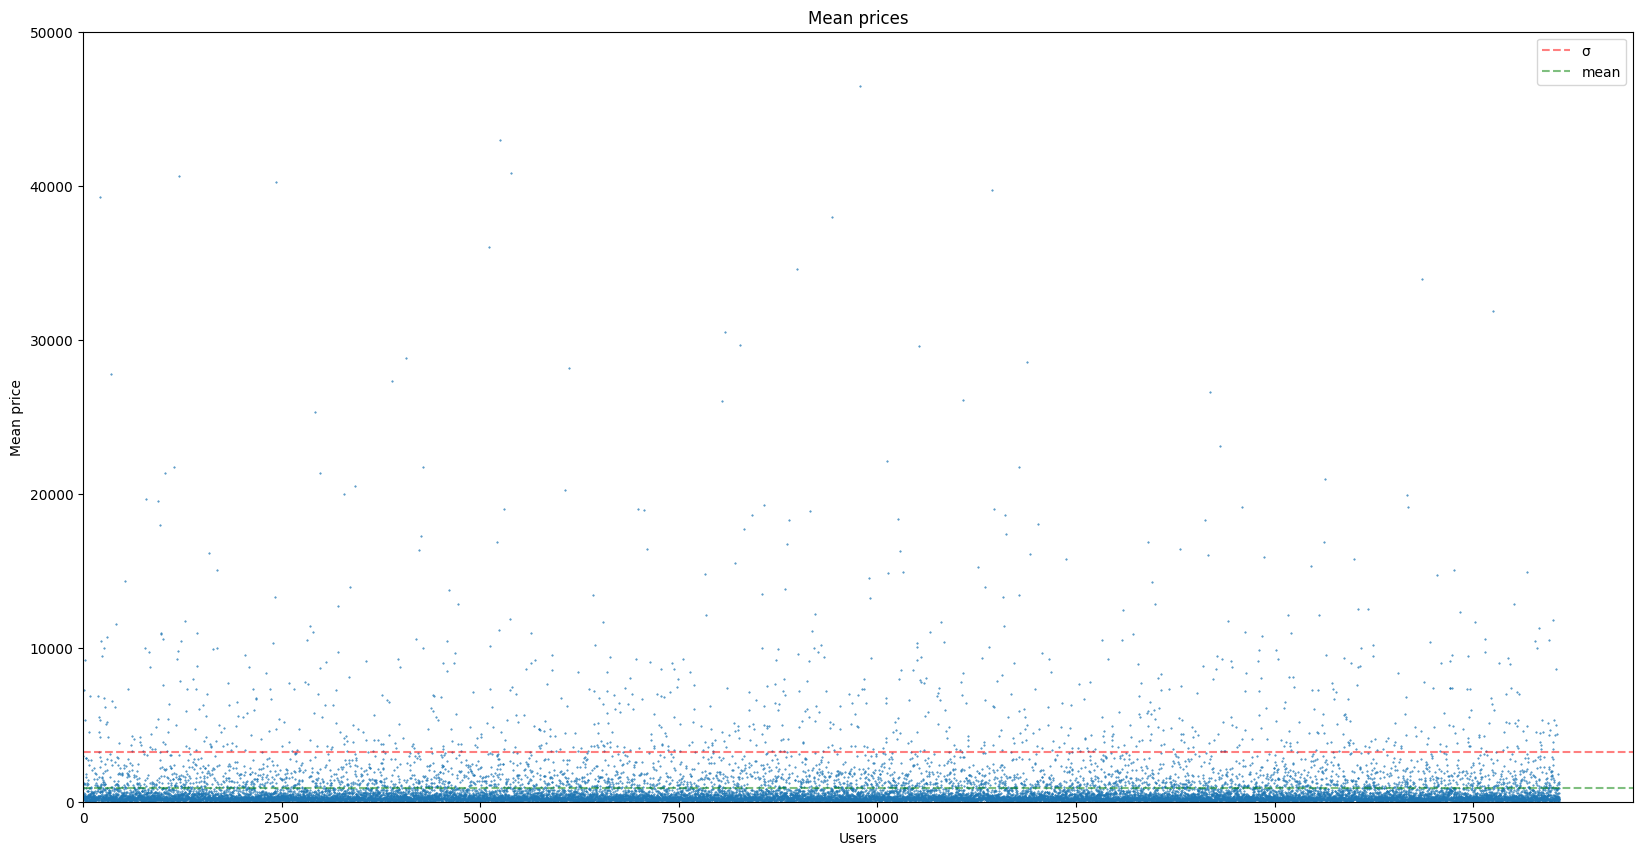

In [52]:
scatter_mean_prices(user_info, ylim=50_000)

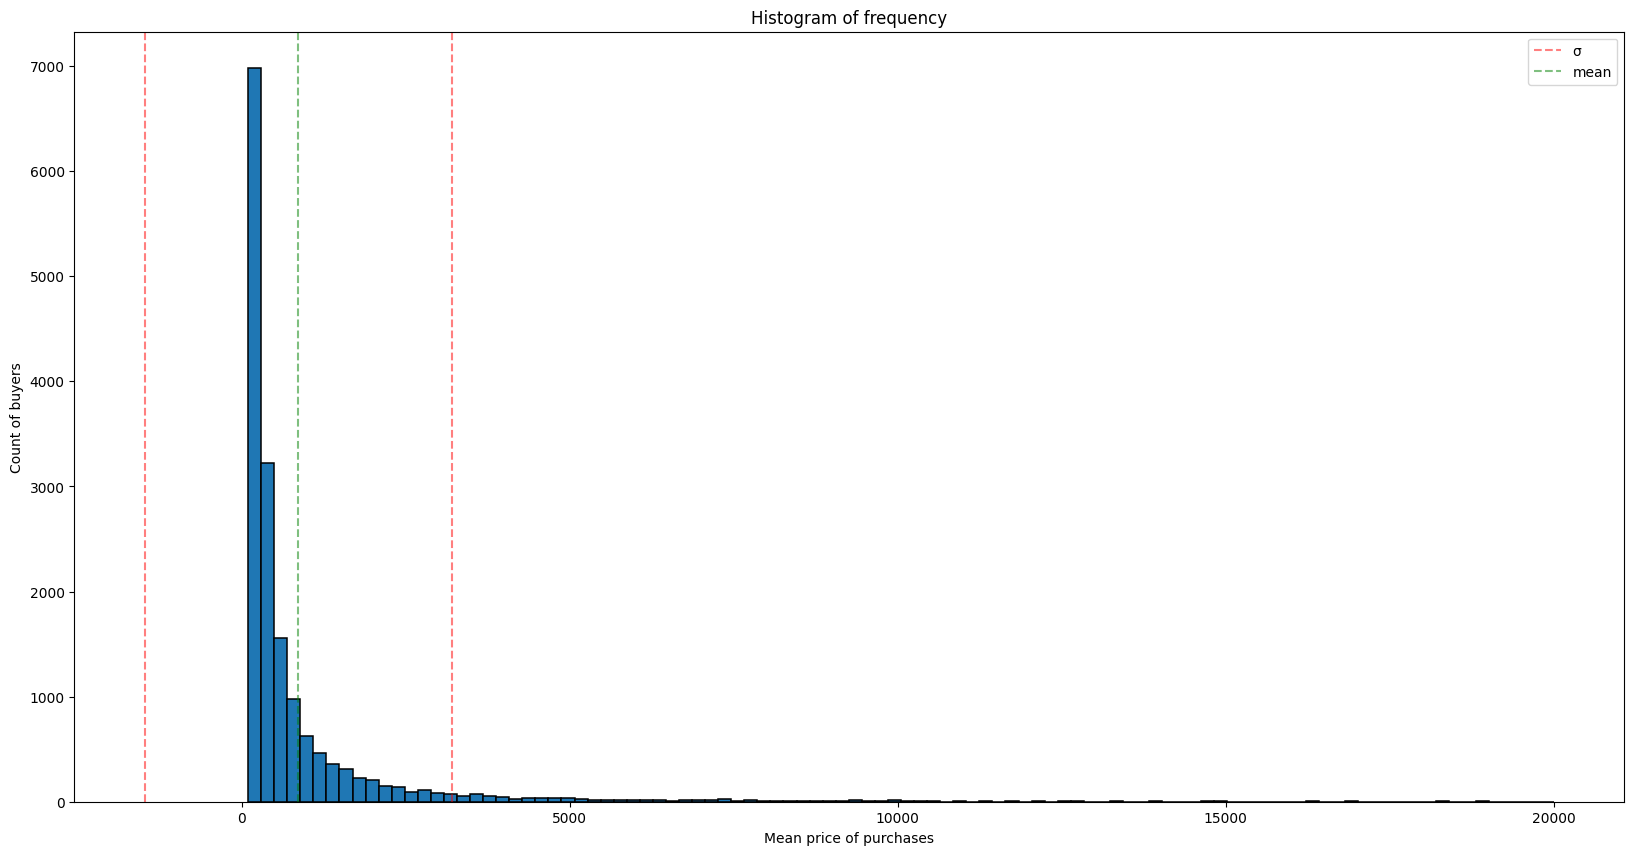

In [53]:
scatter_hist_of_prices(user_info, nbins=100, price_limit=(100, 20_000))

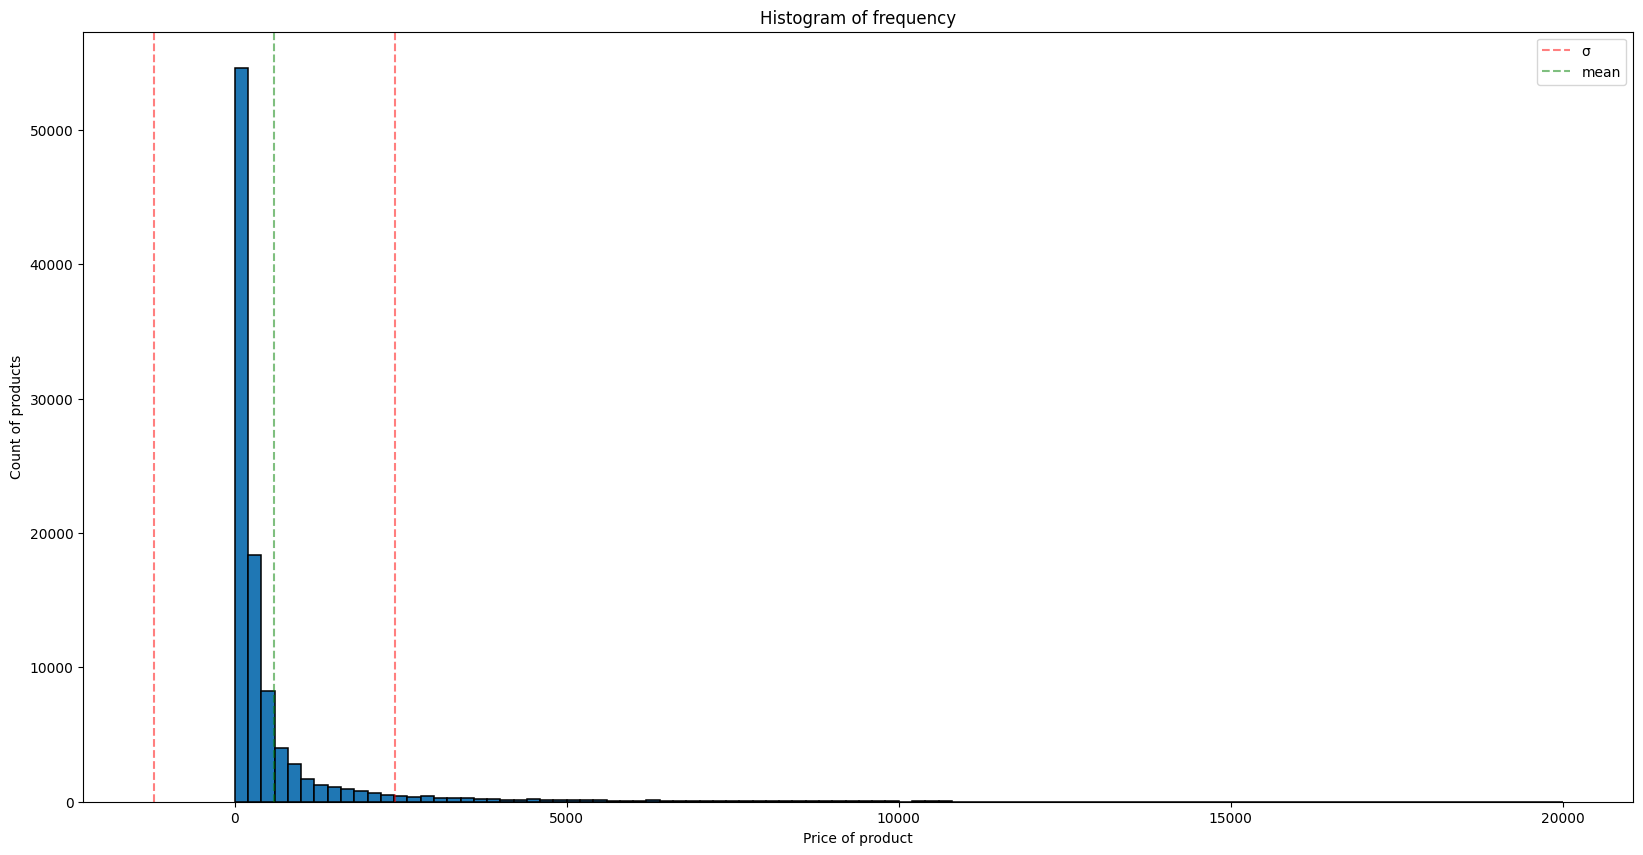

In [54]:
scatter_hist_of_products(data, nbins=100, price_limit=(0, 20_000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


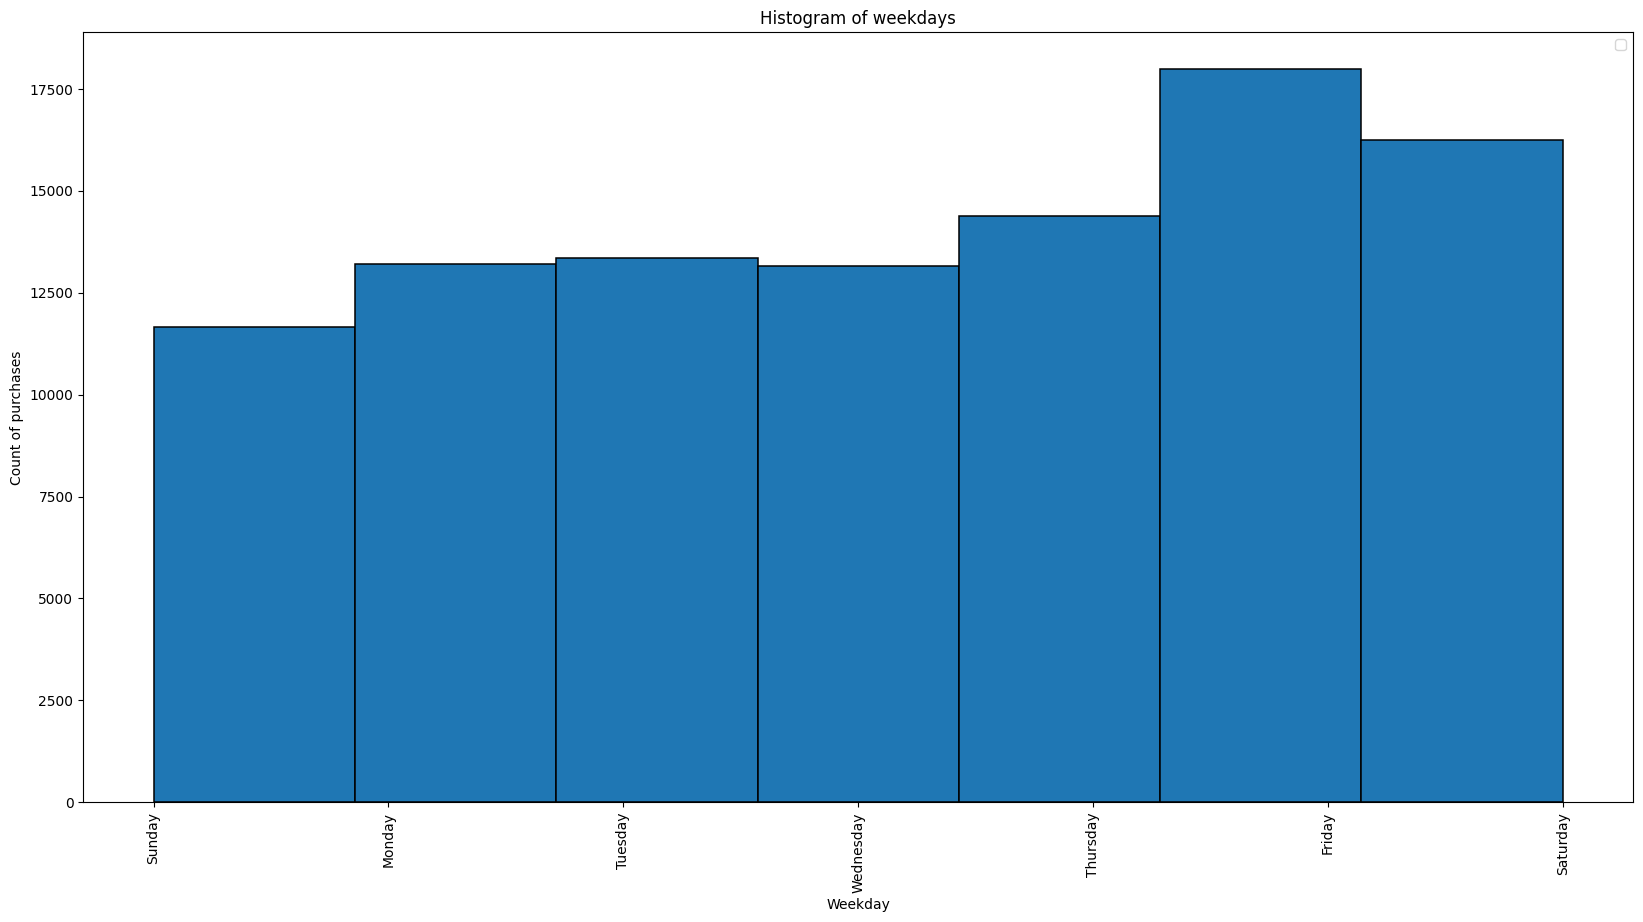

In [48]:
scatter_hist_of_weekdays(data)

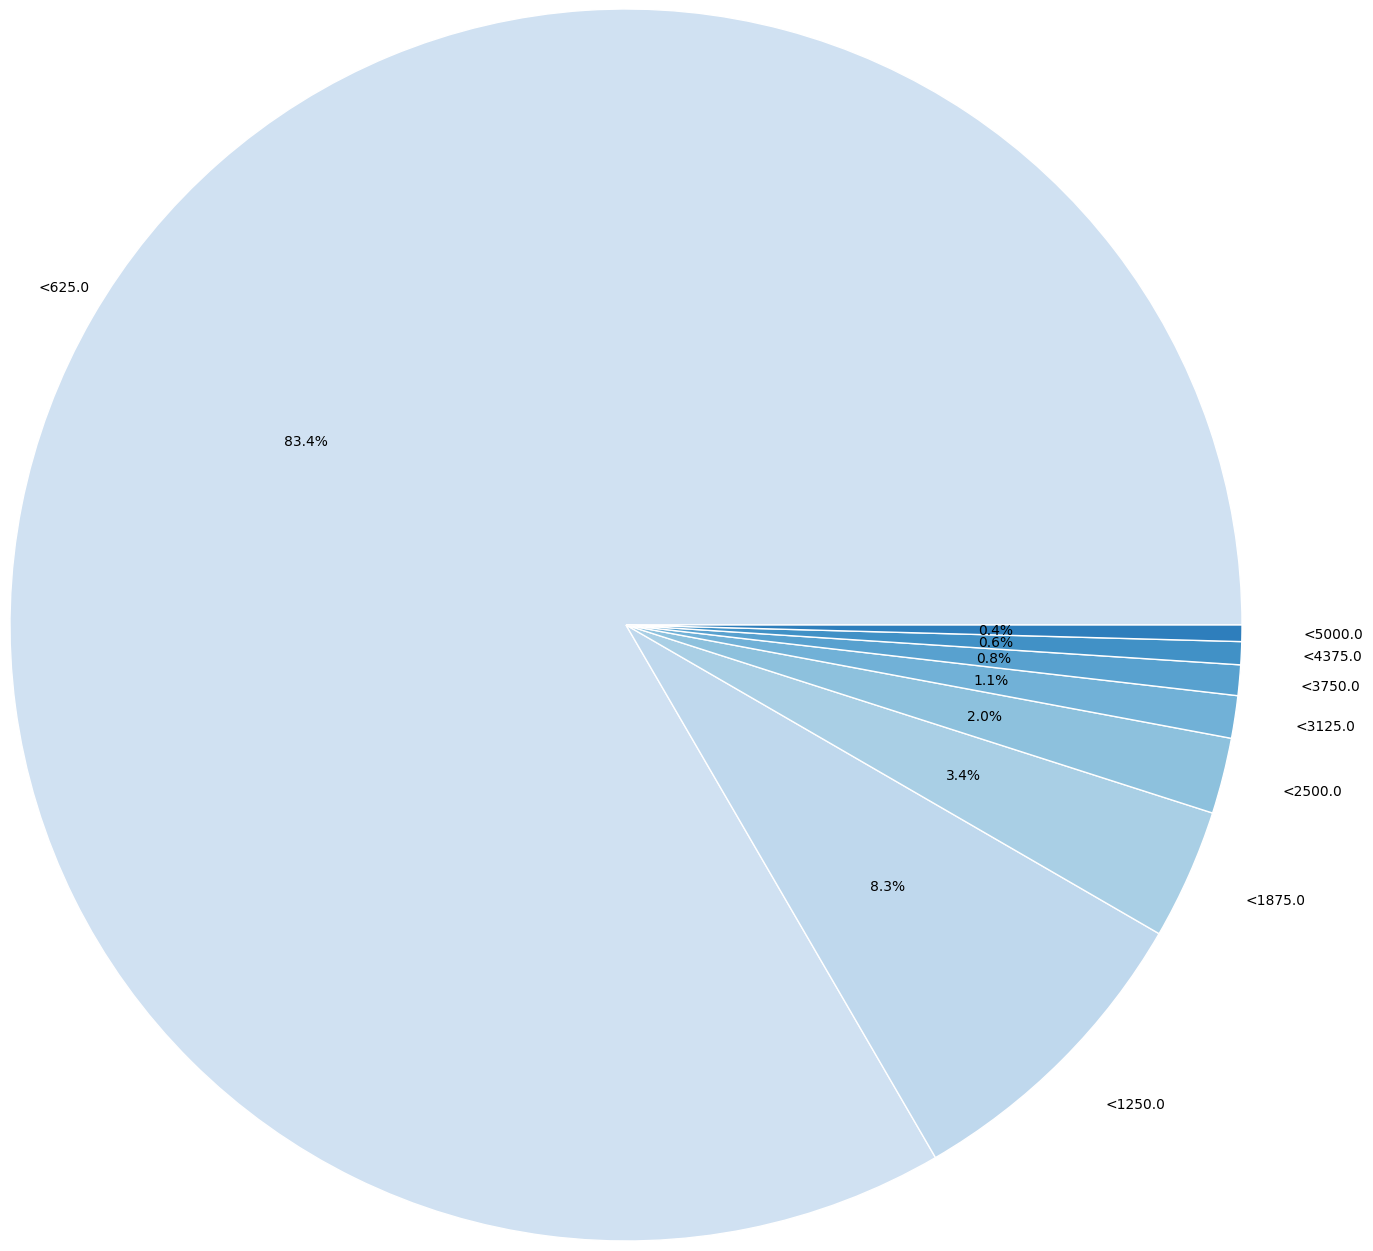

In [144]:
scatter_pie_of_prices(data, nbins=8, top_limit=5_000)

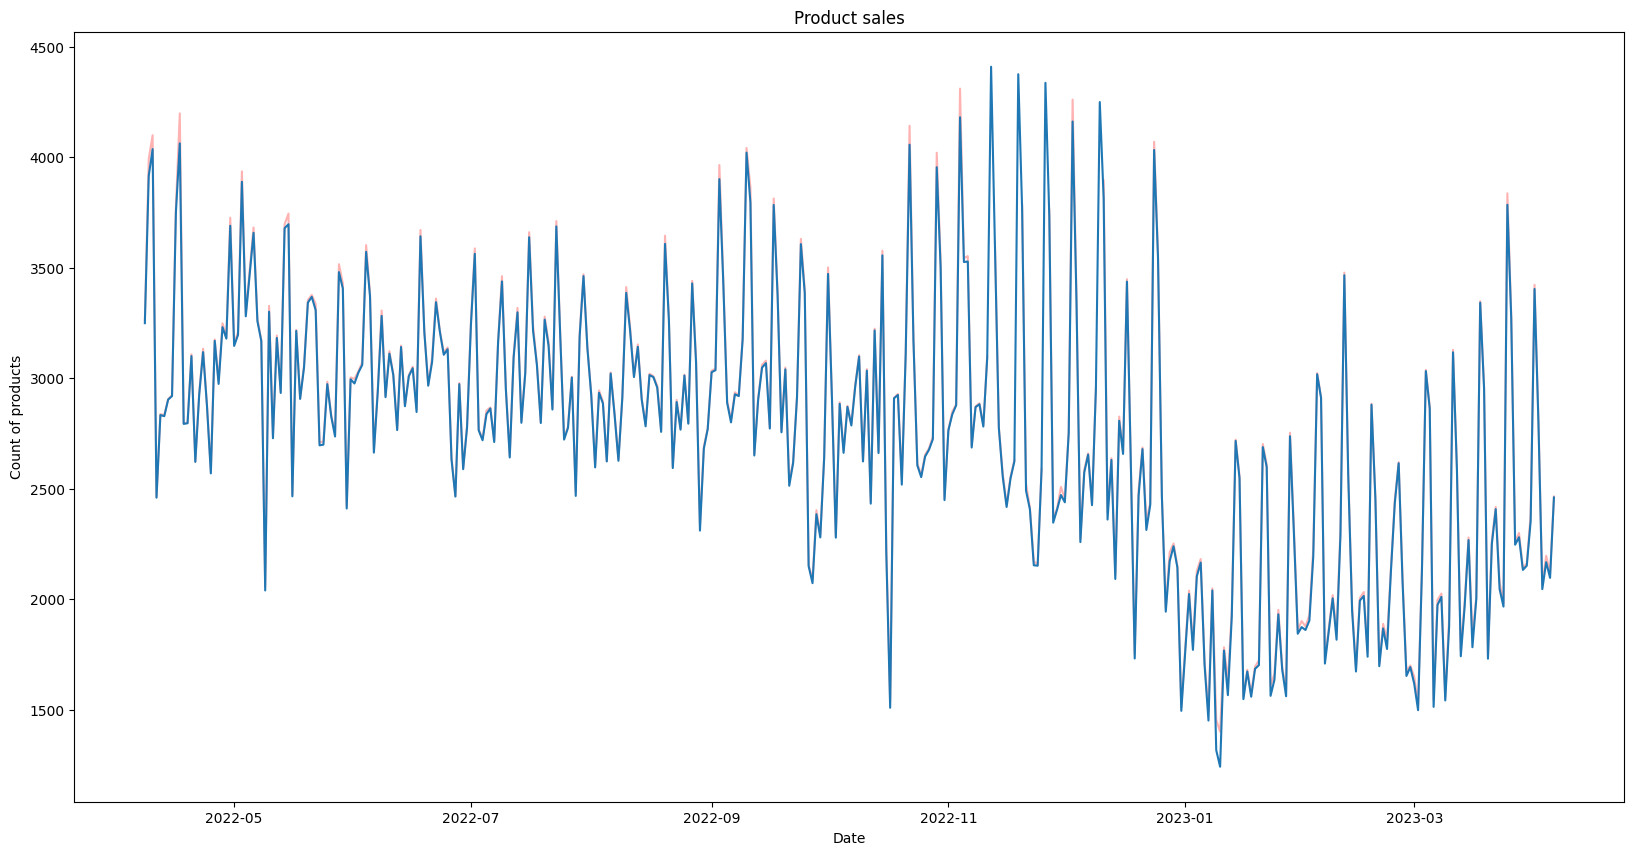

In [145]:
plot_over_time(data)

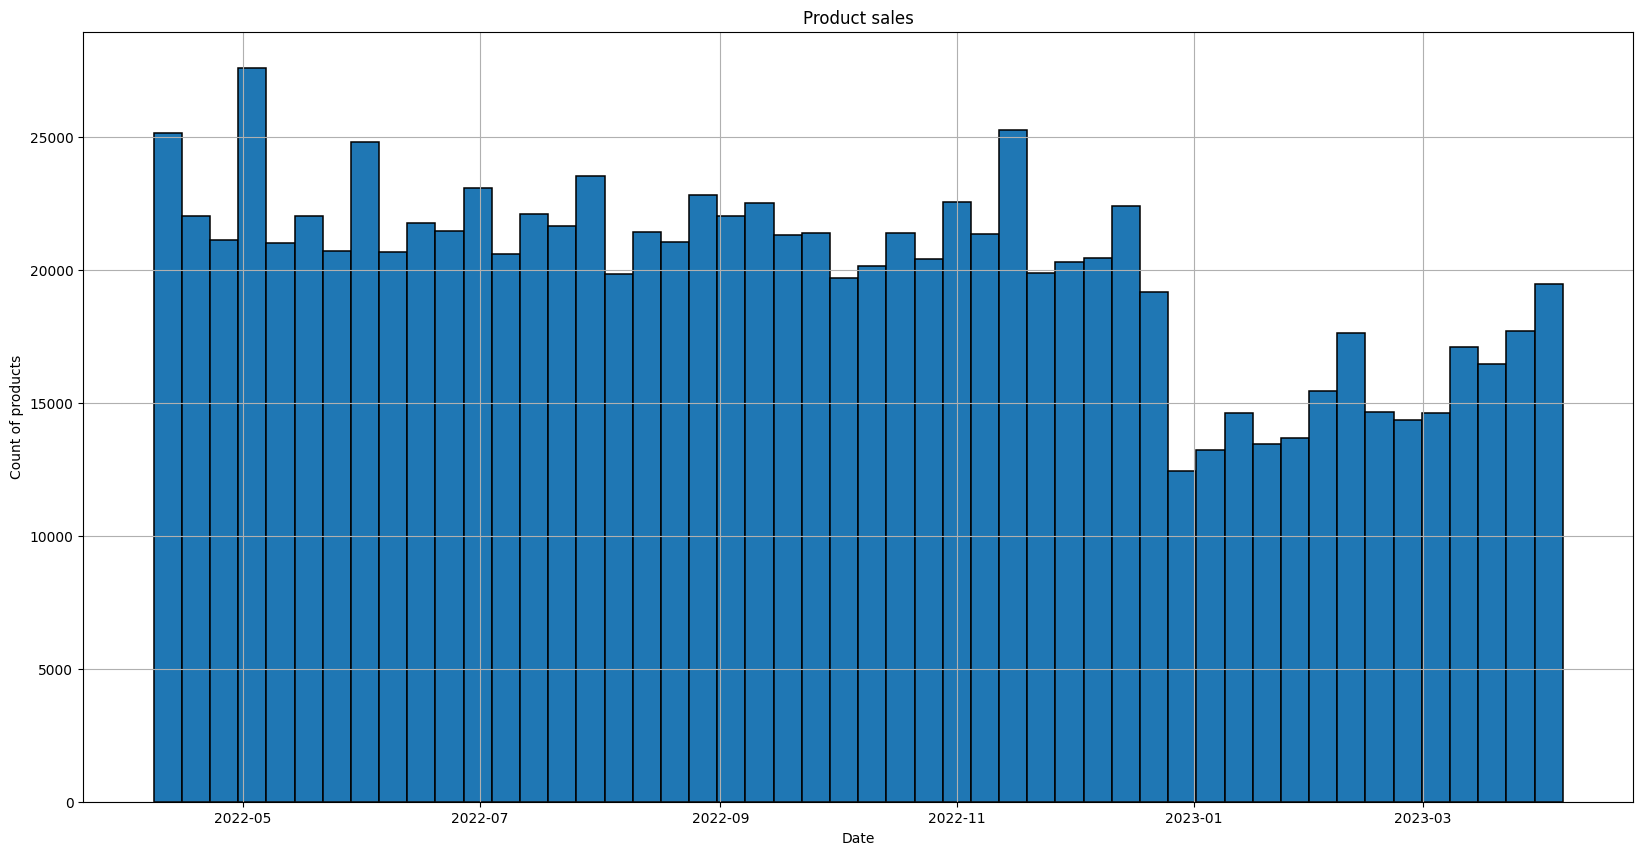

In [148]:
scatter_hist_over_time(data, nbins=50, plot_ma=False)

In [ ]:
def get_user_purchases(data, batch_size):
    """
    :param data: receipts - pandas.DataFrame
    :return: ans: ans[i][j] = count of purchases by the user i of the product j - matrix
    """
    ans = np.zeros((data['gid'].drop_duplicates().shape[0], data['product_id'].drop_duplicates().shape[0]), dtype=np.int8)
    data = data[['gid', 'product_id']]

    def fill_arr(x, arr):
        name = x.name
        for i in x.values:
            arr[name][i] += 1

    def process_batch(batch):
        nonlocal ans
        batch.groupby(by='gid')['product_id'].apply(lambda x: fill_arr(x, ans))

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    for batch in tqdm(np.array_split(data, data.shape[0] / batch_size)):
        batch = process_batch(batch)
        # pool.apply_async(
        #     process_batch,
        #     args=(batch,),
        # )
    pool.close()
    pool.join()

    return ans

In [ ]:
purchases = get_user_purchases(data, batch_size=100_000)
purchases

In [ ]:
three_sigmas(purchases)

In [ ]:
# np.mean(purchases)

### Временные ряды

In [ ]:
class Period:
    def __init__(self, date_from, date_to, date_type='%d.%m.%y'):
        self.start = datetime.strptime(date_from, date_type)
        self.end = datetime.strptime(date_to, date_type)

    def is_in(self, date):
        return self.start <= date <= self.end

    def includes(self, data):
        return data.loc[data.datetime >= self.start].loc[data.datetime <= self.end]

In [ ]:
# def get_from_to(data, date_from, date_to, date_type='%d/%m/%y'):
#     return data.loc[data.datetime >= datetime.strptime(date_from, date_type)].loc[data.datetime <= datetime.strptime(date_to, date_type)]

def get_from_to(data, date_period):
    return date_period.includes(data)

def get_by_weekday(data, weekday):
    i = 0
    for ind in weekday_dict:
        if weekday == weekday_dict[ind]:
            i = ind
    return data.loc[data.weekday == i]

def sort_by_date(data):
    return data.sort_values(by=['datetime'])


# sort_by_date(get_from_to(data, '01.04.22', '20.12.22', '%d.%m.%y'))
# get_by_weekday(data, 'Четверг')

In [ ]:

# sort_by_date(get_from_to(data, Period('01.04.22', '20.12.22', '%d.%m.%y')))

### Эластичность спроса по цене

In [ ]:
def get_elasticity_over_periods(data, product_id, date_period_1, date_period_2):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]

    data_1 = date_period_1.includes(data)
    data_2 = date_period_2.includes(data)

    count_1 = data_1.shape[0]
    count_2 = data_2.shape[0]

    price_1 = data_1['line_item_price'].mean()
    price_2 = data_2['line_item_price'].mean()

    e = ((count_2 - count_1) / count_1) / ((price_2 - price_1) / price_1)
    return e

In [ ]:
def get_dates_when_price_changed(data, product_id):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]
    when_changed = data['line_item_price'].shift() != data['line_item_price']#['datetime']
    return when_changed

In [ ]:
# get_elasticity_over_periods(data, 18785635, Period('19.10.21', '20.12.22'), Period('20.12.22', '22.12.23'))

In [ ]:
# get_dates_when_price_changed(data, 18785635)

In [ ]:
import pandas_profiling
# prof = data.profile_report(progress_bar=True, explorative=True)

In [ ]:
prof = pandas_profiling.ProfileReport(data)
prof.to_file(output_file='out/output.html')